In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from functions import *

In [2]:
# The user can set five flags:

# 1) input data: MNIST or CIFAR10
choose_data = 1  # 1 = MNIST,  2 = CIFAR

# 2) Use dropout or not
dropout = 1  # 1: use dropout; 0: do not use dropout

# 3) type of risk function
type_ = 3  # 1: sigmoid, 2: tanh, 3: rectifier

# 4) type of risk function
cost = 1  # 0: least-squares, 1: cross-entropy

# 5) Choose if the output layer should be softmax
softmax = 1  # set to 1 to use softmax; otherwise set to zero

if choose_data == 1:
    # MNIST dataset
    mnist_data = scipy.io.loadmat("data/mnist_normalized.mat") # loaded mnist data; features are centered and variance-normalized
    features_train = mnist_data["train_features_norm"] # 60,000 x 784
    labels_train = mnist_data["train_norm_labels"] # 10 digit labels 
    features_test = mnist_data["test_features_norm"] # 10,000 x 784
    labels_test = mnist_data["test_norm_labels"] # 10 digit labels

    n2 = 512 # number of nodes in hidden layer 2
    n3 = 512 # number of nodes in hidden layer 3

else:
    # CIFAR-10 dataset
    data_batch_1 = scipy.io.loadmat("data/data_batch_1_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = data_batch_1["train_features_norm_1"] # 10,000 x 3072
    labels_train = data_batch_1["train_labels_norm_1"] # labels 0, 1, ..., 9

    data_batch_2 = scipy.io.loadmat("data/data_batch_2_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_2["train_features_norm_2"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_2["train_labels_norm_2"]]) # labels 0, 1, ..., 9

    data_batch_3 = scipy.io.loadmat("data/data_batch_3_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_3["train_features_norm_3"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_3["train_labels_norm_3"]]) # labels 0, 1, ..., 9

    data_batch_4 = scipy.io.loadmat("data/data_batch_4_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_4["train_features_norm_4"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_4["train_labels_norm_4"]]) # labels 0, 1, ..., 9

    data_batch_5 = scipy.io.loadmat("data/data_batch_5_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_5["train_features_norm_5"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_5["train_labels_norm_5"]]) # labels 0, 1, ..., 9

    test_data_batch = scipy.io.loadmat("data/test_batch_normalized.mat") # loaded CIFAR-10 data; features are centered and variance-normalized.
    features_test = test_data_batch["test_features_norm"]
    labels_test = test_data_batch["test_labels_norm"]

    n2 = 2048 # number of nodes in hidden layer 2
    n3 = 2048 # number of nodes in hidden layer 3

number_of_classes = 10
mu = 0.001 # step-size
rho = 0.0001 # l2-regularization
number_of_passes = 200 # epochs

# dropout parameters
p_vec = [0.1, 0.5, 0.5] # Bernoulli probabilities for input layer and the two hidden layers value of p = probability of node turned off

# Choose type of activation function
if type_ == 1: #1: sigmoid, 2: tanh, 3: rectifier
    activation = "sigmoid"
elif type_ == 2:
    activation = "tanh" 
elif type_ == 3:
    activation = "rectifier"

if cost == 1: # to make sure that when cross-entropy is used, softmax is also used
    softmax = 1

if activation == "rectifier": # to make sure that when rectifier is used, softmax is also used
    softmax = 1

L = 4 # total number of layers, including input and output layers --> L-2 hidden layers

In [5]:
number_of_passes = 10
Wcell, ThetaCell = train_feedforward_neural_network(
    L, number_of_classes, mu, rho, number_of_passes, features_train, labels_train,
    n2, n3, dropout, activation, softmax, p_vec, cost)

100%|██████████| 60000/60000 [04:50<00:00, 206.55it/s]


In [23]:
def adjust_lambda(lambda_, z):
    # lambda: heatmap before transformation
    # z : pre-activation signal
    # lambda_hat: heatmap after transformation

    K = max(lambda_.shape)
    lambda_hat = np.zeros(K)

    for k in range(K):
        if lambda_[k] > 0 and z[k] > 0:
            lambda_hat[k] = lambda_[k]
        else:
            lambda_hat[k] = 0

    return lambda_hat

In [36]:
N_test = features_test.shape[0]

cost = 1 # 1: cross-entropy; 0: least-squares
softmax = 1 # output layer uses softmax

type_ = 2 # 1: sigmoid; 2: rectifier

nL = number_of_classes # size of output layer, which is equal to the number of labels
n1 = features_test.shape[-1] # size of input layer, which is equal to M
n4 = nL # same as output layer
Q = nL # size of output layer; same as nL; which the number of classes as well.

yCell = [None]*L # to save the y vectors across layers
zCell = [None]*L # to save the z vectors across layers
lambdaCell = [None]*L 
lambdaCellhat = [None]*L 
lambdaDeconv = [None]*L 

H = np.zeros((n1, 3)) # save the three random images here
labelsH = np.zeros((3)) # and their labels

lambda1 = np.zeros((n1, 3)) # save the 3 heatmaps from the traditional sensitivity analysis
lambda1_hat = np.zeros((n1, 3)) # from guided backprop
lambda_gradient_input = np.zeros((n1, 3)) # from the gradient x input method
lambda_hat_deconv1 = np.zeros((n1, 3)) # from the DeconvNet method

image_original_list = []
heat_map_1_list = []
heat_map_2_list = []
heat_map_3_list = []
heat_map_4_list = []
heat_map_5_list = []

labels_test = labels_test.reshape(-1)

for r in range(3): # generating three random example
    n = np.random.randint(N_test) # select a random sample
    h = features_test[n]
    m = labels_test[n] # labels assumed to be nonnegative: 0, 1, 2, ...
    gamma = np.zeros(Q) # transform the label into a one-hot encoded vector
    gamma[m] = 1
    q = m 
    eq = np.zeros(Q)
    eq[q] = 1
    H[:, r] = h # save the image to be used under relevance scores below as well
    labelsH[r] = m

    yCell[0] = h 

    for ell in range(L-1): # forward propagation
        Weight = Wcell[ell]
        theta = ThetaCell[ell]
        y = yCell[ell]
        z = Weight@y - theta 
        zCell[ell+1] = z.copy()

        K = z.shape[0]
        y = np.zeros(K) # generating next y 

        for k in range(K):
            y[k] = max(0, z[k])
    
        yCell[ell+1] = y.copy() # save y_{ell+1}

    zL = z.copy()
    yL = yCell[-1]

    K = zL.shape[0]

    gamma_hat = np.exp(zL)/np.exp(zL).sum()

    ax = np.max(gamma_hat) # find location of largest probability
    idx = np.argmax(gamma_hat) 

    lambdaL = (np.eye(Q) - gamma_hat.reshape(-1, 1)@gamma_hat.reshape(1, -1))@eq # sensitivity vector
    lambdaCell[-1] = lambdaL 
    lambdaCellhat[-1] = adjust_lambda(lambdaL, zL) # for guided backprop to get hat{lambda}_L
    lambdaDeconv[-1] = adjust_lambda(lambdaL, lambdaL) # adjust for DeconvNet; just zero negative entries

    for ell in range(L-1, 0, -1): # start of backward propagation
        Weight = Wcell[ell-1]
        lambda_ = lambdaCell[ell]
        lambda_hat = lambdaCellhat[ell] # guided backprop
        lambda_hat_deconv = lambdaDeconv[ell] # DeconvNet method

        if ell >= 2:
            z = zCell[ell-1]
            K = z.shape[0]
            J = np.zeros((K, K))

            for k in range(K):
                if z[k] <= 0: # set, by convention, f'(z) to zero at z=0 for the rectifier function
                    J[k, k] = 0
                else:
                    J[k, k] = 1
        
            lambdaCell[ell-1] = J@((Weight).T@lambda_)

            x = J@((Weight).T@lambda_hat) # guided backprop
            lambdaCellhat[ell-1] = adjust_lambda(x, z)

            s = J@((Weight).T@lambda_hat_deconv) # DeconvNet method
            lambdaDeconv[ell-1] = adjust_lambda(s, s)

        else:
            lambdaCell[ell-1] = Weight.T@lambda_ 

            x = Weight.T@lambda_hat # guided backprop
            lambdaCellhat[ell-1] = adjust_lambda(x, x) 

            s = Weight.T@lambda_hat_deconv 
            lambdaDeconv[ell-1] = adjust_lambda(s, s)
    
    lambda1[:, r] = lambdaCell[0] # traditional sensitivity analysis
    lambda_gradient_input[:, r] = np.multiply(h, lambda1[:, r]) # gradient x input method
    lambda1_hat[:, r] = lambdaCellhat[0] # guided backprop
    lambda_hat_deconv1[:, r] = lambdaDeconv[0] # DeconvNet method

    image_original = h.reshape((28, 28))
    heat_map_1 = lambda1[:, r].reshape((28, 28)) # traditional 
    heat_map_2 = lambda1_hat[:, r].reshape((28, 28)) # guided backprop
    heat_map_3 = lambda_gradient_input[:, r].reshape((28, 28)) # gradient x input
    heat_map_4 = lambda_hat_deconv1[:, r].reshape((28, 28)) # DeconvNet method

epsilon = 1e-6 # to avoid division by zero in relevance calculations

lambda_relevance = np.zeros((n1, 3)) # to save the 3 heatmaps

RCell = [None]*L

for r in range(3): # using the three random examples saved above
    h = H[:, r] # same feature vectors used before
    m = int(labelsH[r]) # and their labels
    gamma = np.zeros(Q) # transform the label into a one-hot encoded vector
    gamma[m] = 1
    q = m
    eq = np.zeros(Q)
    eq[q] = 1

    yCell[0] = h 

    for ell in range(L-1): # forward propagation
        Weight = Wcell[ell]
        theta = ThetaCell[ell]
        y = yCell[ell]
        z = Weight@y - theta 
        zCell[ell+1] = z.copy()

        K = z.shape[0]
        y = np.zeros(K) # generating next y 

        for k in range(K):
            y[k] = max(0, z[k])
    
        yCell[ell+1] = y.copy() # save y_{ell+1}

    zL = z.copy()
    yL = yCell[-1]

    K = zL.shape[0]

    x = zL.copy() # since softmax is being used, we set RL to the pre-activation signal
    RL = np.concatenate([np.zeros(1), eq*x])
    RCell[-1] = RL.copy()

    for ell in range(L-1, 0, -1): # start of backward propagation
        Weight = Wcell[ell-1]
        theta = ThetaCell[ell-1]
        y = yCell[ell-1]
        z = zCell[ell]
        R = RCell[ell]

        na, nb = Weight.shape
        We = np.zeros((na+1, nb+1))
        We[1:na+1, 0] = -theta 
        We[1:na+1, 1:nb+1] = Weight

        ye = np.concatenate([np.ones(1), y])
        ze = np.concatenate([np.zeros(1), z])
        nz = max(ze.shape)
        Ze = epsilon*np.eye(nz) + np.diag(ze)

        xv = We.T@np.linalg.inv(Ze)@R 
        xv = ye*xv 
        RCell[ell-1] = xv
    
    Y = RCell[0]
    ny = max(Y.shape)
    lambda_relevance[:, r] = Y[1:ny] # excluding first entry for the bias

    amin = lambda1[:, r].min()
    amax = lambda1[:, r].max()
    heat1 = (lambda1[:, r]-amin)/(amax-amin) # normalize values to lie in [0, 1]

    amin = lambda1_hat[:, r].min()
    amax = lambda1_hat[:, r].max()
    heat2 = (lambda1_hat[:, r]-amin)/(amax-amin) # normalize values to lie in [0, 1]

    amin = lambda_gradient_input[:, r].min()
    amax = lambda_gradient_input[:, r].max()
    heat3 = (lambda_gradient_input[:, r]-amin)/(amax-amin) # normalize values to lie in [0, 1]

    amin = lambda_hat_deconv1[:, r].min()
    amax = lambda_hat_deconv1[:, r].max()
    heat4 = (lambda_hat_deconv1[:, r]-amin)/(amax-amin) # normalize values to lie in [0, 1]

    amin = lambda_relevance[:, r].min()
    amax = lambda_relevance[:, r].max()
    heat5 = (lambda_relevance[:, r]-amin)/(amax-amin) # normalize values to lie in [0, 1]

    image_original = h.reshape((28, 28))
    heat_map_1 = heat1.reshape((28, 28)) # traditional 
    heat_map_2 = heat2.reshape((28, 28)) # guided backprop
    heat_map_3 = heat3.reshape((28, 28)) # gradient x input
    heat_map_4 = heat4.reshape((28, 28)) # DeconvNet method
    heat_map_5 = heat5.reshape((28, 28)) # relevance scores

    image_original_list.append(image_original)
    heat_map_1_list.append(heat_map_1)
    heat_map_2_list.append(heat_map_2)
    heat_map_3_list.append(heat_map_3)
    heat_map_4_list.append(heat_map_4)
    heat_map_5_list.append(heat_map_5)

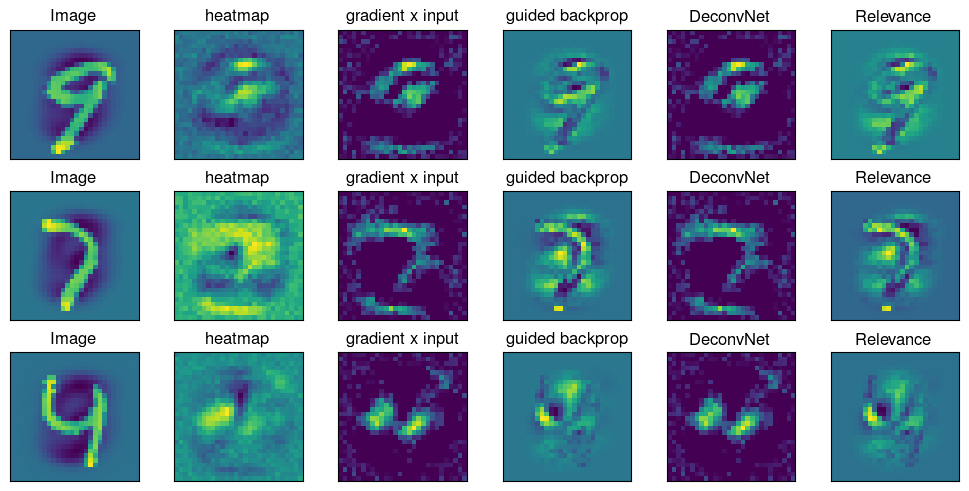

In [45]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

for r in range(3):

    ax = fig.add_subplot(3, 6, r*6+1)
    ax.imshow(image_original_list[r])
    ax.set_title("Image")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(3, 6, r*6+2)
    ax.imshow(heat_map_1_list[r])
    ax.set_title("heatmap")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(3, 6, r*6+3)
    ax.imshow(heat_map_2_list[r])
    ax.set_title("gradient x input")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(3, 6, r*6+4)
    ax.imshow(heat_map_3_list[r])
    ax.set_title("guided backprop")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(3, 6, r*6+5)
    ax.imshow(heat_map_4_list[r])
    ax.set_title("DeconvNet")
    ax.set_xticks([])
    ax.set_yticks([])


    ax = fig.add_subplot(3, 6, r*6+6)
    ax.imshow(heat_map_5_list[r])
    ax.set_title("Relevance")
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

plt.savefig("figs/fig-5.pdf", format="pdf", bbox_inches="tight")
plt.show()